In [1]:
using AutomotiveDrivingModels
using AutoViz
using BayesNets
using DataFrames
using Discretizers
using Distributions
using HDF5
using Interact
using PGFPlots
using TikzPictures

In [2]:
# load the data
input_filepath = "../../data/datasets/2_19/risk_10_sec_10_timesteps.h5"
raw_features = h5open(input_filepath, "r") do file
    read(file, "risk/features")
end;

In [3]:
debug_size = min(10000, size(raw_features, 3))
timestep = size(raw_features, 2)
features = view(raw_features, :, timestep, 1:debug_size)

# discard samples that have features outside of bounds
min_v, max_v = 0., 50.
min_d_fore, max_d_fore = 0., 100.
valid_idxs_v = find(min_v .< features[3,:] .< max_v)
valid_idxs_d_fore = find(min_d_fore .< features[26,:] .< max_d_fore)
valid_idxs_v_fore = find(min_v .< features[27,:] .< max_v)
valid_idxs = intersect(valid_idxs_v, valid_idxs_d_fore, valid_idxs_v_fore)
features = view(features, :, valid_idxs)

# make targets a feature
use_target_variable = true
target_idx = 3
if use_target_variable
    targets = h5open(input_filepath, "r") do file
        read(file, "risk/targets")
    end;
    target = view(targets, target_idx, valid_idxs)
else
    target = zeros(1, size(features, 2))
end

# select features
v = features[3,:]
d_fore = features[26,:]
v_fore = features[27,:];

In [4]:
# discretize the data
# features
num_bins = [5, 5, 5]
data = [v, d_fore, v_fore]
num_samples = length(v)
disc_data = zeros(Int, num_samples, 3)
cutpoints = []
discs = []
for (f, vals) in enumerate(data)
    disc = LinearDiscretizer(binedges(DiscretizeUniformCount(num_bins[f]), vals))
    push!(cutpoints, disc.binedges)
    for (i, val) in enumerate(vals)
        c = 0
        for (c, (lo, hi)) in enumerate(zip(disc.binedges, disc.binedges[2:end]))
            if lo <= val < hi
                break
            end
        end
        disc_data[i, f] = c
    end
end

# targets
disc_target = ones(Int, num_samples)
idxs = find(target .> 0)
disc_target[idxs] = 2;

In [5]:
# convert data to dataframe
data = DataFrame(
        velocity = disc_data[:,1], 
        foredistance = disc_data[:,2], 
        forevelocity = disc_data[:,3],
        target = disc_target
);

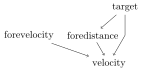

In [6]:
# fit a bayesnet
bn = fit(DiscreteBayesNet, data, 
    (:target=>:foredistance, 
    :target=>:velocity,
    :foredistance=>:velocity,
    :forevelocity=>:velocity)
)

In [7]:
# # could also fit the structure, but skip that for now
# params = GreedyHillClimbing(ScoreComponentCache(data), max_n_parents=3, prior=UniformPrior())
# bn = fit(DiscreteBayesNet, data, params)

In [8]:
# report CPDs
for k in [:velocity, :foredistance, :forevelocity, :target]
    println(table(bn, k))
end

250×5 DataFrames.DataFrame
│ Row │ foredistance │ forevelocity │ target │ velocity │ p         │
├─────┼──────────────┼──────────────┼────────┼──────────┼───────────┤
│ 1   │ 1            │ 1            │ 1      │ 1        │ 0.202851  │
│ 2   │ 2            │ 1            │ 1      │ 1        │ 0.853354  │
│ 3   │ 3            │ 1            │ 1      │ 1        │ 0.698052  │
│ 4   │ 4            │ 1            │ 1      │ 1        │ 0.348958  │
│ 5   │ 5            │ 1            │ 1      │ 1        │ 0.0373134 │
│ 6   │ 1            │ 2            │ 1      │ 1        │ 0.0732394 │
│ 7   │ 2            │ 2            │ 1      │ 1        │ 0.270073  │
│ 8   │ 3            │ 2            │ 1      │ 1        │ 0.353723  │
│ 9   │ 4            │ 2            │ 1      │ 1        │ 0.156863  │
│ 10  │ 5            │ 2            │ 1      │ 1        │ 0.030837  │
│ 11  │ 1            │ 3            │ 1      │ 1        │ 0.0       │
⋮
│ 239 │ 4            │ 3            │ 2      │ 5        │ 0.2

In [9]:
for i in 1:length(bn.cpds)
    println(i)
    println(bn.cpds[i].target)
end


1
target
2
forevelocity
3
foredistance
4
velocity


In [10]:
# build continuous distributions
v_dists = [Uniform(cutpoints[1][i], cutpoints[1][i+1]) for i in 1:(length(cutpoints[1]) - 1)]
d_fore_dists = [Uniform(cutpoints[2][i], cutpoints[2][i+1]) for i in 1:(length(cutpoints[2]) - 1)]
v_fore_dists = [Uniform(cutpoints[3][i], cutpoints[3][i+1]) for i in 1:(length(cutpoints[3]) - 1)];

In [11]:
rand(bn.cpds[1])

1

In [20]:
# generate a lane
function generate_lane(num_veh = 10)
    t_cpd_idx = 1
    fore_v_cpd_idx = 2
    fore_d_cpd_idx = 3
    v_cpd_idx = 4
    v_cpd = bn.cpds[v_cpd_idx]
    states = zeros(num_veh, 4)

    # sample the initial car
    state = rand(bn)
    v, fore_d, fore_v, t = state[:velocity], state[:foredistance], state[:forevelocity], state[:target]
    states[1, 1] = rand(v_dists[v])
    states[1, 2] = rand(d_fore_dists[fore_d])
    states[1, 3] = rand(v_fore_dists[fore_v])
    states[1, 4] = t

    for veh_idx in 2:num_veh
        # sample the target
        t = rand(bn.cpds[t_cpd_idx])
        
        # sample the distance bin
        fore_d = rand(bn.cpds[fore_d_cpd_idx], :target=>t)

        # sample the velocity bin
        v = rand(bn.cpds[v_cpd_idx], :forevelocity=>fore_v, :foredistance=>fore_d, :target=>t)

        # sample the float values uniformly
        states[veh_idx, 1] = rand(v_dists[v])
        states[veh_idx, 2] = rand(d_fore_dists[fore_d])
        states[veh_idx, 3] = rand(v_fore_dists[fore_v])
        states[veh_idx, 4] = t

        # replace the fore velocity with the current one
        fore_v = v
    end
    return states
end

generate_lane (generic function with 2 methods)

In [21]:
# scene feature extractors
function get_features(scene::Scene, roadway::Roadway)
    # feature containers, censors
    timegaps = zeros(Float64, length(scene))
    timegap_censor_hi = 10.
    ttcs = zeros(Float64, length(scene))
    ttc_censor_hi = 30.
    velocities = zeros(Float64, length(scene))
    distance_fores = zeros(Float64, length(scene))
    distance_fore_censor_hi = 100.
    
    for veh_idx in 1:length(scene)
        ego_veh = scene.vehicles[veh_idx]
        velocities[veh_idx] = ego_veh.state.v
        
        neigh = get_neighbor_fore_along_lane(scene, veh_idx, roadway)
        
        # if the fore vehicle does not exist then set as censor high
        if neigh.ind == 0
            timegaps[veh_idx] = timegap_censor_hi
            distance_fores[veh_idx] = distance_fore_censor_hi
            ttcs[veh_idx] = ttc_censor_hi
        else
            # get both vehicles 
            rear_veh = scene.vehicles[veh_idx]
            fore_veh = scene.vehicles[neigh.ind]
            
            # want the time for the rear vehicle's front to reach the fore vehicle's back
            v = rear_veh.state.v
            
            # first term is distance between centers
            # second moves from fore vehicle center to back bumper
            # third moves from rear vehicle center to front bumper
            Δs = (fore_veh.state.posF.s - rear_veh.state.posF.s) - (fore_veh.def.length / 2) - (rear_veh.def.length / 2)
            timegaps[veh_idx] = min(Δs / v, timegap_censor_hi)
            
            # distance fore
            distance_fores[veh_idx] = min(Δs, distance_fore_censor_hi)
            
            # time to collision
            Δv = fore_veh.state.v - rear_veh.state.v
            if Δv < 0.
                ttcs[veh_idx] = min(max(-1 * Δs / Δv, 0.), ttc_censor_hi)
            else # this means fore vehicle moving away too quickly
                ttcs[veh_idx] = ttc_censor_hi
            end
            
        end
    end
    return timegaps, ttcs, velocities, distance_fores
end

get_features (generic function with 1 method)

Interact.Options{:ToggleButtons,Int64}(Signal{Int64}(1, nactions=1),"veh_idx",1,"1",Interact.OptionDict(DataStructures.OrderedDict("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…),Dict(68=>"68",2=>"2",89=>"89",11=>"11",39=>"39",46=>"46",85=>"85",25=>"25",55=>"55",42=>"42"…)),Any[],Any[],true,"horizontal")

Interact.Options{:ToggleButtons,Int64}(Signal{Int64}(1, nactions=1),"lane_idx",1,"1",Interact.OptionDict(DataStructures.OrderedDict("1"=>1,"2"=>2,"3"=>3,"4"=>4),Dict(4=>"4",2=>"2",3=>"3",1=>"1")),Any[],Any[],true,"horizontal")

Interact.Options{:ToggleButtons,Float64}(Signal{Float64}(1.0, nactions=1),"zoom",1.0,"1.0",Interact.OptionDict(DataStructures.OrderedDict("1.0"=>1.0,"2.0"=>2.0,"3.0"=>3.0,"4.0"=>4.0,"5.0"=>5.0,"6.0"=>6.0,"7.0"=>7.0,"8.0"=>8.0,"9.0"=>9.0,"10.0"=>10.0…),Dict(7.0=>"7.0",4.0=>"4.0",9.0=>"9.0",10.0=>"10.0",2.0=>"2.0",3.0=>"3.0",5.0=>"5.0",8.0=>"8.0",6.0=>"6.0",1.0=>"1.0"…)),Any[],Any[],true,"horizontal")

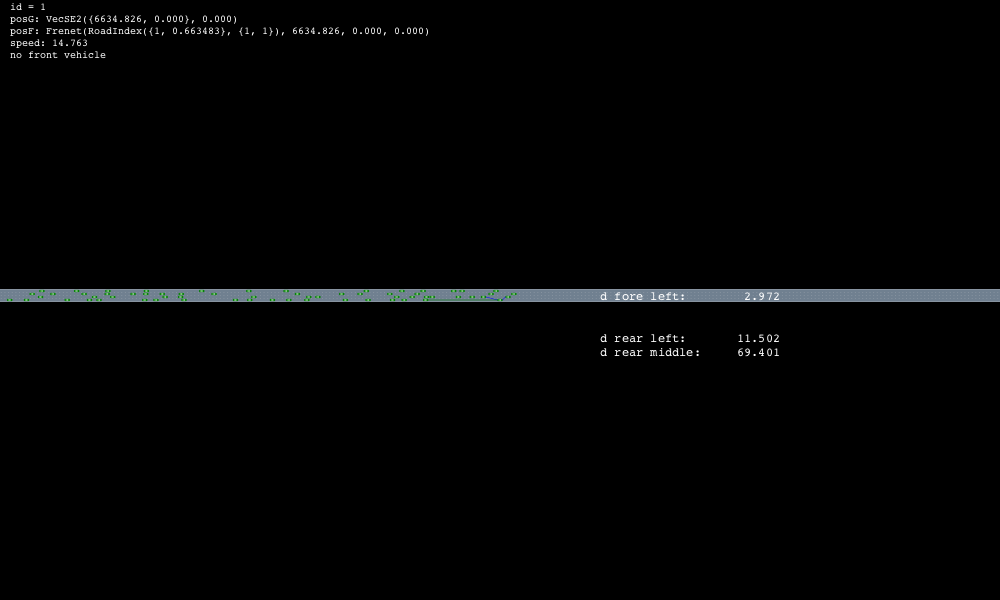

In [30]:
# populate and display a scene
context = IntegratedContinuous(.1, 1) 
num_lanes = 4
num_veh = 100
num_scenes = 1000
roadway_length = 10000.
roadway = gen_straight_roadway(num_lanes, roadway_length)

# track features 
emergent = Dict{String, Array{Float64}}()
emergent["timegap"] = zeros(Float64, num_scenes * num_veh * num_lanes)
emergent["ttc"] = zeros(Float64, num_scenes * num_veh * num_lanes)
emergent["velocity"] = zeros(Float64, num_scenes * num_veh * num_lanes)
emergent["distance_fore"] = zeros(Float64, num_scenes * num_veh * num_lanes)

# unpack indices
v_idx, fore_d_idx, fore_v_idx, t_idx = 1, 2, 3, 4

# build the scene
scene = Scene(num_veh * num_lanes)
carcolors = Dict{Int,Colorant}()
for scene_idx in 1:num_scenes
    empty!(scene)
    for lane_idx in 1:num_lanes
        states = generate_lane(num_veh)
        remaining_length = roadway_length * 2. / 3.
        for veh_idx in 1:num_veh
            veh_id = veh_idx + (lane_idx - 1) * num_veh
            # if this car was sampled as a hard brake, then color it
            if states[veh_idx, t_idx] == 2
                carcolors[veh_id] = colorant"red"
            else
                carcolors[veh_id] = colorant"green"
            end
            
            remaining_length -= states[veh_idx, fore_d_idx]
            if remaining_length > 0
                road_idx = RoadIndex(proj(VecSE2(0.0, 3. * (lane_idx-1), 0.0), roadway))
                base_speed = states[veh_idx, v_idx]
                veh_state = VehicleState(Frenet(road_idx, roadway), roadway, base_speed)
                veh_state = move_along(veh_state, roadway, remaining_length)
                veh_def = VehicleDef(veh_id, AgentClass.CAR, 5., 2.)
                push!(scene, Vehicle(veh_state, veh_def))
            else
                break
            end
        end
    end
    # compute features of scene
    timegaps, ttcs, velocities, distance_fores = get_features(scene, roadway)
    s = (scene_idx - 1) * num_lanes * num_veh
    e = s + num_lanes * num_veh
    emergent["timegap"][s+1:e] = timegaps
    emergent["ttc"][s+1:e] = ttcs
    emergent["velocity"][s+1:e] = velocities
    emergent["distance_fore"][s+1:e] = distance_fores
end

# or just look at it
@manipulate for veh_idx in collect(1:num_veh),
                lane_idx in collect(1:num_lanes),
              zoom in collect(1:10.)
    veh_id = veh_idx + (lane_idx - 1) * num_veh
    stats = [CarFollowingStatsOverlay(veh_id, 2), 
        NeighborsOverlay(veh_id, textparams = TextParams(x = 600, y_start=300))]
        
    render(scene, roadway, stats, cam = CarFollowCamera(veh_id, zoom), car_colors = carcolors)
end

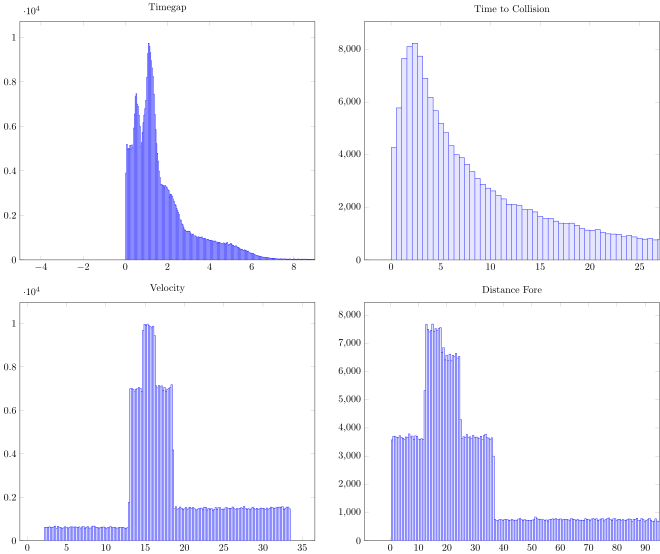

In [31]:
# analyze emergent behavior
g = GroupPlot(2, 2, groupStyle = "horizontal sep = 1.75cm, vertical sep = 1.5cm")
nbins = 100
timegap_axis = Axis(Plots.Histogram(emergent["timegap"], bins=nbins), 
                    ymin=0, 
                    xmax=9, 
                    xmin=-5,
                    width="12cm",
                    height="10cm",
                    title="Timegap")
push!(g, timegap_axis)
ttc_axis = Axis(Plots.Histogram(emergent["ttc"], bins=nbins), 
                    ymin=0, 
                    xmax=27,
                    width="12cm",
                    height="10cm",
                    title="Time to Collision")
push!(g, ttc_axis)
velocity_axis = Axis(Plots.Histogram(emergent["velocity"], bins=nbins), 
                    ymin=0,  
                    width="12cm",
                    height="10cm",
                    title="Velocity")
push!(g, velocity_axis)
distance_fore_axis = Axis(Plots.Histogram(emergent["distance_fore"], bins=nbins), 
                    ymin=0,  
                    xmax=95,
                    width="12cm",
                    height="10cm",
                    title="Distance Fore")
push!(g, distance_fore_axis)
g

In [32]:
TikzPictures.save("/Users/wulfebw/Desktop/hist_hard_brake.pdf", g)

In [ ]:
cutpoints